<a href="https://colab.research.google.com/github/Heineken-H41/WincFinal/blob/main/WINCFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, linregress
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import re
from functools import reduce
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [15]:
# 'All Countries' list to apply on databases to exclude micro- or macro regions and non-countries (such as World, Curaçao, Asia, Low-income countries, etc)
countries = [
    "Afghanistan",
    "Albania",
    "Algeria",
    "Andorra",
    "Angola",
    "Antigua and Barbuda",
    "Argentina",
    "Armenia",
    "Australia",
    "Austria",
    "Azerbaijan",
    "Bahamas",
    "Bahrain",
    "Bangladesh",
    "Barbados",
    "Belarus",
    "Belgium",
    "Belize",
    "Benin",
    "Bhutan",
    "Bolivia",
    "Bosnia and Herzegovina",
    "Botswana",
    "Brazil",
    "Brunei",
    "Bulgaria",
    "Burkina Faso",
    "Burundi",
    "Cape Verde",
    "Cambodia",
    "Cameroon",
    "Canada",
    "Central African Republic",
    "Chad",
    "Chile",
    "China",
    "Colombia",
    "Comoros",
    "Congo",
    "Costa Rica",
    "Croatia",
    "Cuba",
    "Cyprus",
    "Czechia",
    "Democratic Republic of Congo",
    "Denmark",
    "Djibouti",
    "Dominica",
    "Dominican Republic",
    "Ecuador",
    "Egypt",
    "El Salvador",
    "Equatorial Guinea",
    "Eritrea",
    "Estonia",
    "Eswatini",
    "Ethiopia",
    "Fiji",
    "Finland",
    "France",
    "Gabon",
    "Gambia",
    "Georgia",
    "Germany",
    "Ghana",
    "Greece",
    "Grenada",
    "Guatemala",
    "Guinea",
    "Guinea-Bissau",
    "Guyana",
    "Haiti",
    "Holy See",
    "Honduras",
    "Hungary",
    "Iceland",
    "India",
    "Indonesia",
    "Iran",
    "Iraq",
    "Ireland",
    "Israel",
    "Italy",
    "Jamaica",
    "Japan",
    "Jordan",
    "Kazakhstan",
    "Kenya",
    "Kiribati",
    "Kuwait",
    "Kyrgyzstan",
    "Laos",
    "Latvia",
    "Lebanon",
    "Lesotho",
    "Liberia",
    "Libya",
    "Liechtenstein",
    "Lithuania",
    "Luxembourg",
    "Madagascar",
    "Malawi",
    "Malaysia",
    "Maldives",
    "Mali",
    "Malta",
    "Marshall Islands",
    "Mauritania",
    "Mauritius",
    "Mexico",
    "Micronesia (country)",
    "Moldova",
    "Monaco",
    "Mongolia",
    "Montenegro",
    "Morocco",
    "Mozambique",
    "Myanmar",
    "Namibia",
    "Nauru",
    "Nepal",
    "Netherlands",
    "New Zealand",
    "Nicaragua",
    "Niger",
    "Nigeria",
    "North Korea",
    "North Macedonia",
    "Norway",
    "Oman",
    "Pakistan",
    "Palau",
    "Palestine",
    "Panama",
    "Papua New Guinea",
    "Paraguay",
    "Peru",
    "Philippines",
    "Poland",
    "Portugal",
    "Qatar",
    "Romania",
    "Russia",
    "Rwanda",
    "Saint Kitts and Nevis",
    "Saint Lucia",
    "Saint Vincent and the Grenadines",
    "Samoa",
    "San Marino",
    "Sao Tome and Principe",
    "Saudi Arabia",
    "Senegal",
    "Serbia",
    "Seychelles",
    "Sierra Leone",
    "Singapore",
    "Slovakia",
    "Slovenia",
    "Solomon Islands",
    "Somalia",
    "South Africa",
    "South Korea",
    "South Sudan",
    "Spain",
    "Sri Lanka",
    "Sudan",
    "Suriname",
    "Sweden",
    "Switzerland",
    "Syria",
    "Taiwan",
    "Tajikistan",
    "Tanzania",
    "Thailand",
    "East Timor",
    "Togo",
    "Tonga",
    "Trinidad and Tobago",
    "Tunisia",
    "Turkey",
    "Turkmenistan",
    "Tuvalu",
    "Uganda",
    "Ukraine",
    "United Arab Emirates",
    "United Kingdom",
    "United States",
    "Uruguay",
    "Uzbekistan",
    "Vanuatu",
    "Venezuela",
    "Vietnam",
    "Yemen",
    "Zambia",
    "Zimbabwe"
]


# Function to see whether in a column of a database contains all countries in the countries list, and if not present find matches to subsequently manually harmonize-
# the 'countries' list (for example: "Timor-leste" was adjusted to "East Timor" manually in the list)
# can be ignored
def find_missing_countries(dataframe, column):
    missing_countries = []
    for country in countries:
        if country not in dataframe[column].unique():
            missing_countries.append(country)
    print("Missing countries:", missing_countries)

    # Check for individual words in missing country names
    for missing_country in missing_countries:
        words = set(missing_country.replace('-', ' ').split())  # Split by space and ignore duplicates
        possible_matches = {}
        for word in words:
            matches = [item for item in dataframe[column] if word.lower() in item.lower()]
            possible_matches[word] = matches
        print(f"Possible matches for '{missing_country}':", possible_matches)

In [16]:
# NAN-value analysis - Copied from lesson in the 'managing datasets' module from WINC
# can be ignored

def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)


def look_at_unique_values(column):
  unique_values_cutoff = 160
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values == len(column):
    print(f"Each value in the column is unique (total: {num_unique_values})")
  elif num_unique_values < unique_values_cutoff:
    print(f"Less than {unique_values_cutoff} unique values:")
    # We may get an error when sorting
    try:
      sorted = np.sort(unique_values)
      print("Values are sorted")
      display(list(sorted))
    except:
      print("Could not sort values")
      display(list(unique_values))
  else:
    print(f"More than {unique_values_cutoff} unique values (total: {num_unique_values})")


def look_at_edges(df, column_name):
  # inner function
  def show_head_and_tail(values):
      num_items_to_slice = 10
      display(list(values)[:num_items_to_slice])
      display(list(values)[-num_items_to_slice:])

  column = df[column_name]
  unique_values = column.unique()
  try:
      sorted = np.sort(unique_values)
      print("Unique values sorted, head and tail:")
      show_head_and_tail(sorted)
  except TypeError as error:
      print(f"Could not sort values: {error}")
      print("..so let's try filtering NULL values and then sorting")
      non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
      sorted = np.sort(non_null_uniques)
      show_head_and_tail(sorted)


def cast_to_type(column, maybe_type):
  try:
    column.astype(maybe_type)
    print(f"Casting to {maybe_type} was successful")
  except ValueError as error:
    print(f"Could not cast to {maybe_type}: {error}")


def find_non_default_missing_values(df, column_name, maybe_type):
  long_separator_amount = 80
  short_separator_amount = 40

  print_separator("*", long_separator_amount, f"Finding non default missing values for column \"{column_name}\"")

  print(f"Column \"{column_name}\" has datatype: {df.dtypes[column_name]}")

  column = df[column_name]

  # A
  print_separator("-", short_separator_amount, "A: Looking at unique values")
  look_at_unique_values(column)

  # B
  print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
  look_at_edges(df, column_name)

  # C
  print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
  cast_to_type(column, maybe_type)

  # D
  print_separator("-", short_separator_amount, "D: Looking at frequency")
  display(column.value_counts(dropna=False))

  print("\n")

# QUESTION 1


---



In [17]:

#URLS used for Question 1
url_A = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/co2-per-capita-marimekko.csv'
url_B = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/gdp-per-capita-worldbank.csv'
url_C = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/meat-production-tonnes.csv'
url_D = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/gdp-vs-manufacturing-gdp.csv'
url_E = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/oil-production-by-country.csv'
url_F = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/fossil-electricity-per-capita.csv'
url_G = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/coal-production-by-country.csv'
url_H = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/gas-production-by-country.csv'

# Reading dataframes from URLs
co2_df = pd.read_csv(url_A)
gdp_per_capita_df = pd.read_csv(url_B)
meat_prod_tonnes_df = pd.read_csv(url_C)
gdp_vs_manufacturing_df = pd.read_csv(url_D)
oil_prod_df = pd.read_csv(url_E)
electricity_fossil_fuels_df = pd.read_csv(url_F)
coal_prod_df = pd.read_csv(url_G)
gas_prod_df = pd.read_csv(url_H)


# List of dataframes
dfs = [co2_df, gdp_per_capita_df, meat_prod_tonnes_df, gdp_vs_manufacturing_df, oil_prod_df, electricity_fossil_fuels_df, coal_prod_df, gas_prod_df]
# Drop the 'Code' column in all dataframes and only use data from 2000 or later
dfs = [df.drop('Code', axis=1).loc[df['Year'] >= 2000].copy() for df in dfs]
# Filter dataframes as per conditions
co2_df, gdp_per_capita_df, meat_prod_tonnes_df, gdp_vs_manufacturing_df, oil_prod_df, electricity_fossil_fuels_df, coal_prod_df, gas_prod_df = dfs

# MODIFICATIONS ON INDIVIDUAL DATAFRAMES
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Specific modifications for co2_df
co2_df.drop(['Continent'], axis=1, inplace=True)
co2_df.rename(columns={'Annual CO₂ emissions (per capita)': 'CO2 emissions per capita (t)', 'Population (historical estimates)': 'Population (millions)'	}, inplace=True)
co2_df.dropna(subset=['CO2 emissions per capita (t)'], inplace=True)
co2_df['Population (millions)'] = (co2_df['Population (millions)'] / 1000000).round(3) # conversion of population to millions: column name was already renamed previously

# Specific modifications for gdp_per_capita_df
gdp_per_capita_df.rename(columns={'GDP per capita, PPP (constant 2017 international $)': 'GDP per capita (thousands $)'}, inplace=True)
gdp_per_capita_df.dropna(subset=['GDP per capita (thousands $)'], inplace=True)
gdp_per_capita_df['GDP per capita (thousands $)'] = (gdp_per_capita_df['GDP per capita (thousands $)'] / 1000).round(3) # conversion of GDP/capita to thousands: column name was already renamed previously

# Specific modifications for meat_prod_tonnes_df
meat_prod_tonnes_df.rename(columns={'Meat, total | 00001765 || Production | 005510 || tonnes': 'Meat production (tonnes)'}, inplace=True)

# Specific modifications for gdp_vs_manufacturing_df
gdp_vs_manufacturing_df = gdp_vs_manufacturing_df.iloc[:, :3]
gdp_vs_manufacturing_df.rename(columns={'Share of industry in GDP at current prices (Herrendorf et al. and GGDC-10 data)': 'Share of industry in GDP (%)'}, inplace=True)


# Creation of fossil_fuel_prod_df (total fossil fuel production) from other dataframes
dfs_to_merge = [oil_prod_df, gas_prod_df, coal_prod_df]
# Perform outer join on 'Entity' and 'Year' for each dataframe
fossil_fuel_prod_df = reduce(lambda left, right: pd.merge(left, right, on=['Entity', 'Year'], how='outer'), dfs_to_merge)
fossil_fuel_prod_df['Total produced fossil fuels (TWh)'] = (fossil_fuel_prod_df['Oil production (TWh)']
                                                            + fossil_fuel_prod_df['Gas production (TWh)']
                                                            + fossil_fuel_prod_df['Coal production (TWh)']).round(3) # Accumulation of TWh of fossil fuel sources
fossil_fuel_prod_df.drop(['Oil production (TWh)', 'Gas production (TWh)', 'Coal production (TWh)' ], axis=1, inplace=True) # Columns no longer needed


# Specific modifications for electricity_fossil_fuels_df
electricity_fossil_fuels_df.rename(columns={'Fossil fuel electricity per capita - kWh': 'Fossil fuel electricity used per capita (kWh)'}, inplace=True)
electricity_fossil_fuels_df = electricity_fossil_fuels_df[electricity_fossil_fuels_df['Fossil fuel electricity used per capita (kWh)'] > 0.0].copy()
# values with 0.0 as fossil fuel electricity used are dropped as they are seen as missing values
# every country in the world at least uses fossil fuels to some degree. Obivious examples of missing values in the original dataframe are among others Albania and Paraguay


# CREATION OF FINAL DATAFRAME Question 1
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# List of dataframes to merge
dfs_to_merge = [co2_df, gdp_per_capita_df, meat_prod_tonnes_df, gdp_vs_manufacturing_df, fossil_fuel_prod_df, electricity_fossil_fuels_df]

# Merge dataframes
merged_df_Q1 = reduce(lambda left, right: pd.merge(left, right, on=['Entity', 'Year'], how='outer'), dfs_to_merge)
# Filter entities to comply with the countries list
merged_df_Q1 = merged_df_Q1[merged_df_Q1['Entity'].isin(countries)].copy()
merged_df_Q1.dropna(subset=['CO2 emissions per capita (t)'], inplace=True)
merged_df_Q1 = merged_df_Q1.dropna(thresh=merged_df_Q1.shape[1]-5) # Remove rows from the DataFrame that have fewer than (number of columns - 5) non-null values.

# Convert 'Total produced fossil fuels (TWh)' column to KWh and divide by 'Population (millions)' to get 'Fossil fuels produced per capita (KWh)'
merged_df_Q1['Fossil fuels produced per capita (KWh)'] = merged_df_Q1['Total produced fossil fuels (TWh)'] * 1000000 / (merged_df_Q1['Population (millions)'] * 1000000).copy()
merged_df_Q1.drop(['Total produced fossil fuels (TWh)'], axis=1, inplace=True)  # Column no longer needed

display(merged_df_Q1)


,Entity,Year,CO2 emissions per capita (t),Population (millions),GDP per capita (thousands $),Meat production (tonnes),Share of industry in GDP (%),Fossil fuel electricity used per capita (kWh),Fossil fuels produced per capita (KWh)
0,Afghanistan,2000,0.053581,19.543,NaN,320785.50,NaN,8.187080,0.127923
1,Afghanistan,2001,0.054300,19.689,NaN,278743.34,NaN,4.571165,0.035197
2,Afghanistan,2002,0.063856,21.000,1.280,304321.20,NaN,6.190400,0.031619
3,Afghanistan,2003,0.068871,22.645,1.292,298619.03,NaN,13.689474,0.018547
4,Afghanistan,2004,0.052529,23.554,1.260,322976.88,NaN,14.010625,0.017577
...,...,...,...,...,...,...,...,...,...
5303,Zimbabwe,2017,0.630165,14.751,2.332,777033.70,NaN,206.764220,NaN
5304,Zimbabwe,2018,0.711830,15.052,2.400,794490.50,NaN,247.804460,NaN
5305,Zimbabwe,2019,0.636645,15.355,2.203,823656.20,NaN,238.364960,NaN
5306,Zimbabwe,2020,0.500945,15.670,1.990,815165.20,NaN,216.979780,NaN


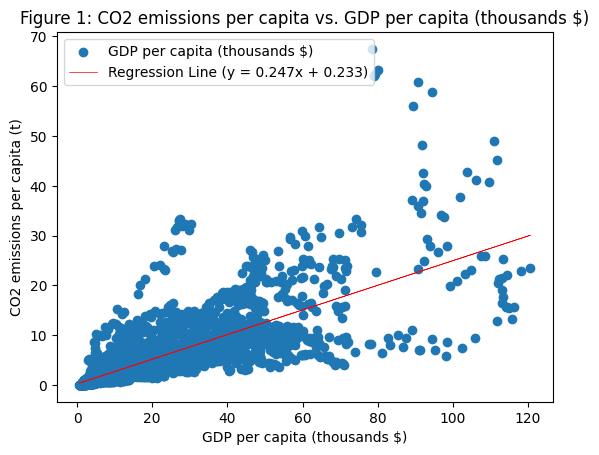

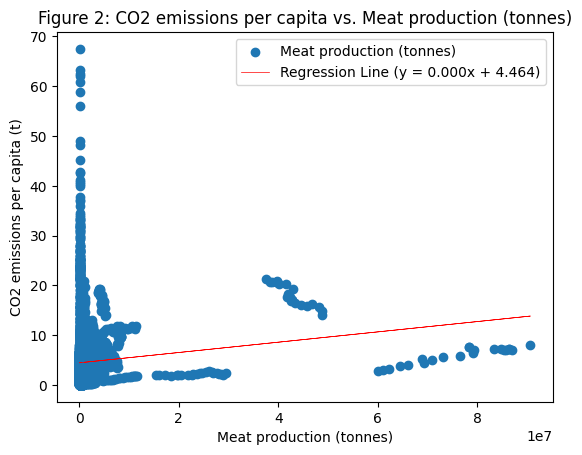

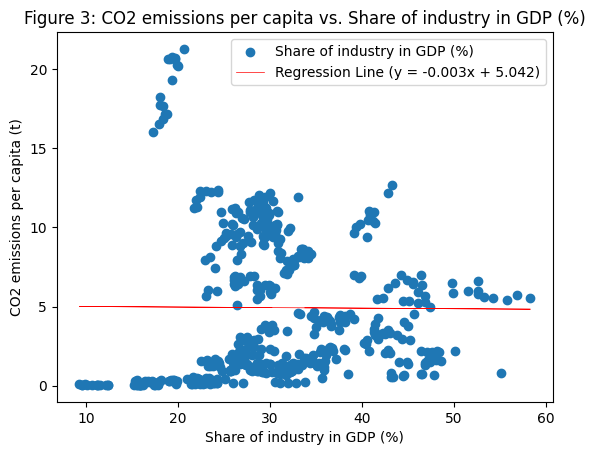

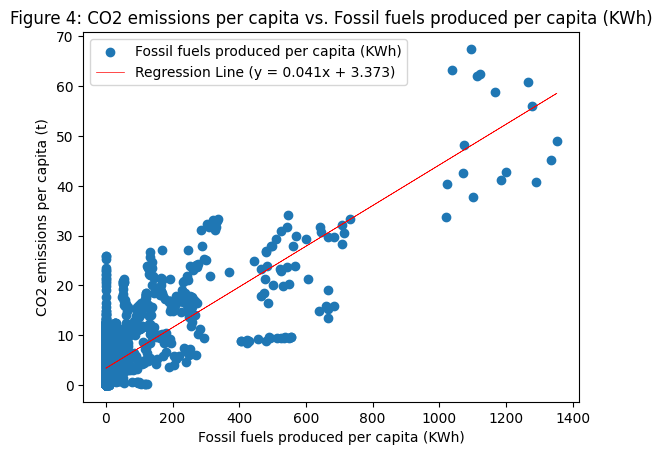

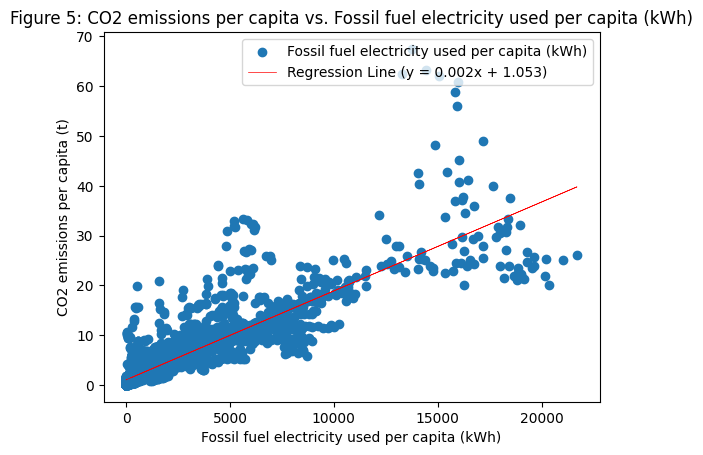

,Factor,Pearson Correlation Coefficient,P-value,Linear Regression Equation,Correlation of Linear Trendline
0,GDP per capita (thousands $),0.7646,0.0000,y = 0.247x + 0.233,0.5846
1,Meat production (tonnes),0.1102,0.0000,y = 0.000x + 4.464,0.0121
2,Share of industry in GDP (%),-0.0069,0.8766,y = -0.003x + 5.042,0.0000
3,Fossil fuels produced per capita (KWh),0.7464,0.0000,y = 0.041x + 3.373,0.5571
4,Fossil fuel electricity used per capita (kWh),0.8672,0.0000,y = 0.002x + 1.053,0.7520


In [18]:

# List of columns to plot against CO2 emissions per capita
columns_to_plot = ['GDP per capita (thousands $)', 'Meat production (tonnes)', 'Share of industry in GDP (%)', 'Fossil fuels produced per capita (KWh)',
                   'Fossil fuel electricity used per capita (kWh)']

#initiate list for dataframes containing information for later concat
stats_dfs = []

# initiate figure count
figure_count = 1

# Iterate through each column to plot each on
for column in columns_to_plot:

    # Drop rows with NaN values in the selected column and 'CO2 emissions per capita (t)'
    valid_data = merged_df_Q1[[column, 'CO2 emissions per capita (t)']].dropna()

    # Plot CO2 emissions per capita against the current column
    plt.scatter(valid_data[column], valid_data['CO2 emissions per capita (t)'], label=column)

    # Fit a linear regression model
    slope, intercept, r_value, p_value_lr, std_err = linregress(valid_data[column], valid_data['CO2 emissions per capita (t)'])

    # Plot the regression line
    plt.plot(valid_data[column], slope*valid_data[column] + intercept, color='red', linestyle='-', linewidth='0.5', label=f'Regression Line (y = {slope:.3f}x + {intercept:.3f})')

    plt.xlabel(column)
    plt.ylabel('CO2 emissions per capita (t)')
    plt.title(f'Figure {figure_count}: CO2 emissions per capita vs. {column}')
    plt.legend()
    plt.show()
    figure_count += 1

    # Calculate correlation coefficient using pearsonr
    correlation_coefficient, p_value = pearsonr(valid_data['CO2 emissions per capita (t)'], valid_data[column])
    correlation_coefficient_rounded = round(correlation_coefficient, 4)
    p_value_rounded = round(p_value, 4)
    r_value_rounded = round(r_value, 4)
    Correlation_of_Linear_Trendline = round(r_value_rounded**2, 4)
    # Create a dataframe with stats to concatenate later on
    stats_df = pd.DataFrame({'Factor': [column],
                             'Pearson Correlation Coefficient': [correlation_coefficient_rounded],
                             'P-value': [p_value_rounded],
                             'Linear Regression Equation': [f'y = {slope:.3f}x + {intercept:.3f}'],
                             'Correlation of Linear Trendline': [Correlation_of_Linear_Trendline]})
    # Add dataframe to the list for concatenation
    stats_dfs.append(stats_df)

results_stats_df = pd.concat(stats_dfs, ignore_index=True)

display(results_stats_df)



# QUESTION 2

---






In [6]:
# URL used for Question 2
url_I = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/annual-co2-emissions-per-country.csv'
co2_total_df = pd.read_csv(url_I)

# Specific modifications for co2_total_df
co2_total_df.rename(columns={'Annual CO₂ emissions': 'CO2 emissions total (Gt)'}, inplace=True)
co2_total_df.dropna(subset=['CO2 emissions total (Gt)'], inplace=True)
co2_total_df['CO2 emissions total (Gt)'] = (co2_total_df['CO2 emissions total (Gt)'] / 1000000000) # Conversion of tonnes to Gigatonnes: column name was already renamed previously
co2_total_df.drop(columns=['Code'], inplace=True)

# Merging of dataframes
co2_emissions_df_Q2 = pd.merge(co2_df, co2_total_df, on=['Entity', 'Year'], how='inner') # inner merge on co2_df from Question 1
co2_emissions_df_Q2.drop(columns=['Population (millions)'], inplace=True)

# Filter data for the years 2000 and 2022 to calculate the percentual difference between this dates
filtered_df = co2_emissions_df_Q2[(co2_emissions_df_Q2['Year'] == 2000) | (co2_emissions_df_Q2['Year'] == 2022)]

# Pivot the DataFrame to have years as columns
pivoted_df = filtered_df.pivot(index='Entity', columns='Year', values=['CO2 emissions per capita (t)', 'CO2 emissions total (Gt)', ])

# Calculate percentual difference
percent_diff_df = (((pivoted_df[('CO2 emissions total (Gt)', 2022)] - pivoted_df[('CO2 emissions total (Gt)', 2000)]) / pivoted_df[('CO2 emissions total (Gt)', 2000)]) * -100).round(1)
percent_diff_df = percent_diff_df.rename('TOTAL CO2 emission Percentual Decrease 2000 - 2022 (%)')

# Similarly, calculate for 'Per Capita CO2'
percent_diff_per_capita_df = (((pivoted_df[('CO2 emissions per capita (t)', 2022)] - pivoted_df[('CO2 emissions per capita (t)', 2000)]) / pivoted_df[('CO2 emissions per capita (t)', 2000)]) * -100).round(1)
percent_diff_per_capita_df = percent_diff_per_capita_df.rename('PER CAPITA CO2 emission Percentual Decrease 2000 - 2022 (%)')


# Concatenate the results into a single DataFrame
result_df = pd.concat([percent_diff_df, percent_diff_per_capita_df], axis=1)

# Reset index to have 'Entity' as a column instead of index
result_df.reset_index(inplace=True)
result_df = result_df[result_df['Entity'].isin(countries)]
# Print or further use result_df
display(result_df)


,Entity,TOTAL CO2 emission Percentual Decrease 2000 - 2022 (%),PER CAPITA CO2 emission Percentual Decrease 2000 - 2022 (%)
0,Afghanistan,-1060.1,-451.2
2,Albania,-63.8,-83.4
3,Algeria,-106.5,-41.5
4,Andorra,29.6,41.7
5,Angola,-0.5,53.7
...,...,...,...
224,Venezuela,46.2,53.5
225,Vietnam,-537.1,-412.6
228,Yemen,27.8,60.1
229,Zambia,-400.1,-147.1


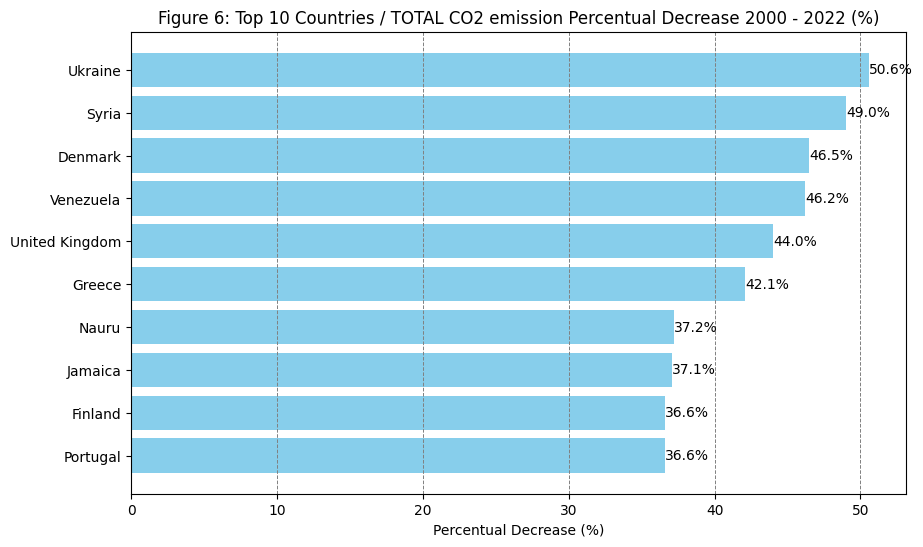

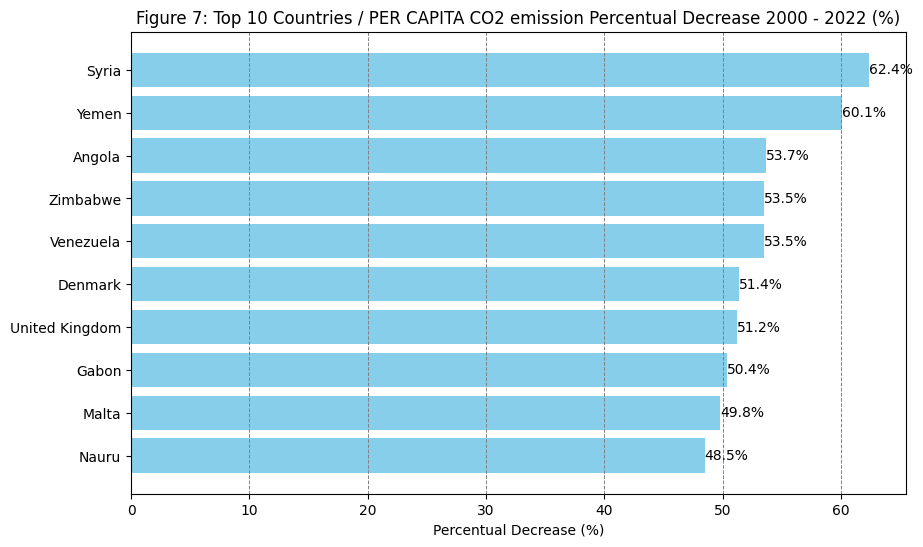

,TOTAL CO2 emission Percentual Decrease 2000 - 2022 (%) Percentual Decrease,PER CAPITA CO2 emission Percentual Decrease 2000 - 2022 (%) Percentual Decrease
Country,,
Denmark,46.5,51.4
Nauru,37.2,48.5
Syria,49.0,62.4
United Kingdom,44.0,51.2
Venezuela,46.2,53.5


In [7]:

columns_to_plot = ['TOTAL CO2 emission Percentual Decrease 2000 - 2022 (%)', 'PER CAPITA CO2 emission Percentual Decrease 2000 - 2022 (%)' ]

figure_count = 6  # manual setting of figure count needed as running this section more times results in accumulation of the figure count

countries = []  #initiate list for dataframe in following loop

# create graph per column
for column in columns_to_plot:
    sorted_data = result_df.sort_values(by=column, ascending=False)
    # Get the top 10 rows with the greatest decrease for the current column
    top_10 = sorted_data.head(10)[['Entity', column]]

    # Plot the data
    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_10['Entity'], top_10[column], color='skyblue')
    plt.xlabel('Percentual Decrease (%)')
    plt.title(f'Figure {figure_count}: Top 10 Countries / {column}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the largest value at the top
    plt.grid(axis='x', linestyle='--', linewidth='0.7', color='gray')

    # Add annotations
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center')

    # append to the list 'countries' for creation of a results table
    for label, width in zip(top_10['Entity'], top_10[column]):
        countries.append({'Country': label, f'{column} Percentual Decrease': width})

    plt.show()
    figure_count += 1

#create table that show countries in both top 10s
df_countries = pd.DataFrame(countries)
df_countries = df_countries.groupby('Country').first().dropna()


display(df_countries)



# QUESTION 3


---



In [8]:
url_J = 'https://raw.githubusercontent.com/Heineken-H41/WincFinal/main/levelized-cost-of-energy.csv'
green_energy_prices_df = pd.read_csv(url_J)

# Filter columns containing 'energy'
energy_columns = [col for col in green_energy_prices_df.columns if 'energy' in col]


# Group by 'Year' column and sum the energy columns
grouped_df_Q3 = green_energy_prices_df.groupby('Year')[energy_columns].mean()
for col in energy_columns:
    new_col = col.replace("levelized cost of energy", " : Global average cost ($/kWh)")
    grouped_df_Q3.rename(columns={col: new_col}, inplace=True)


display(grouped_df_Q3)

,Bioenergy : Global average cost ($/kWh),Geothermal : Global average cost ($/kWh),Offshore wind : Global average cost ($/kWh),Solar photovoltaic : Global average cost ($/kWh),Concentrated solar power : Global average cost ($/kWh),Hydropower : Global average cost ($/kWh),Onshore wind : Global average cost ($/kWh)
Year,,,,,,,
1984,NaN,NaN,NaN,NaN,NaN,NaN,0.293489
1985,NaN,NaN,NaN,NaN,NaN,NaN,0.291157
1986,NaN,NaN,NaN,NaN,NaN,NaN,0.266537
1987,NaN,NaN,NaN,NaN,NaN,NaN,0.258164
1988,NaN,NaN,NaN,NaN,NaN,NaN,0.224598
1989,NaN,NaN,NaN,NaN,NaN,NaN,0.210766
1990,NaN,NaN,NaN,NaN,NaN,NaN,0.217603
1991,NaN,NaN,NaN,NaN,NaN,NaN,0.214469
1992,NaN,NaN,NaN,NaN,NaN,NaN,0.215368


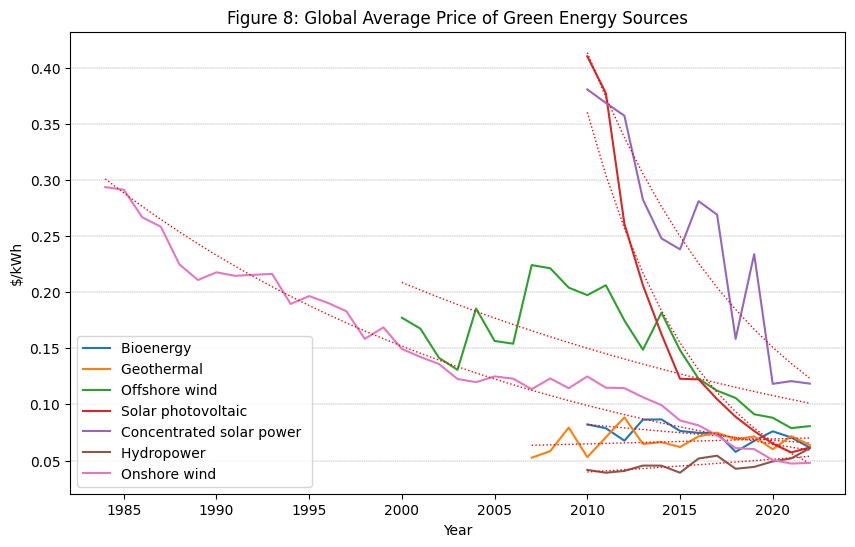

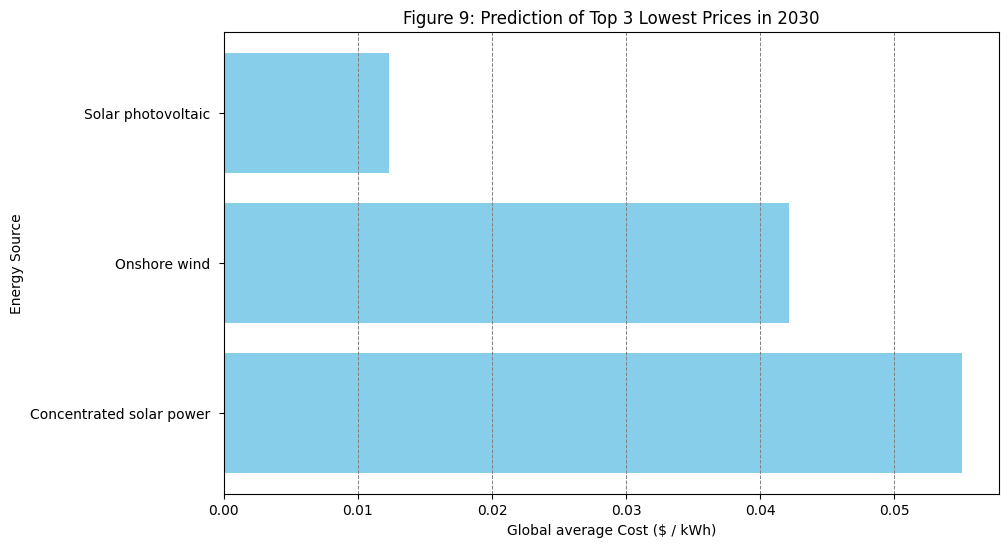

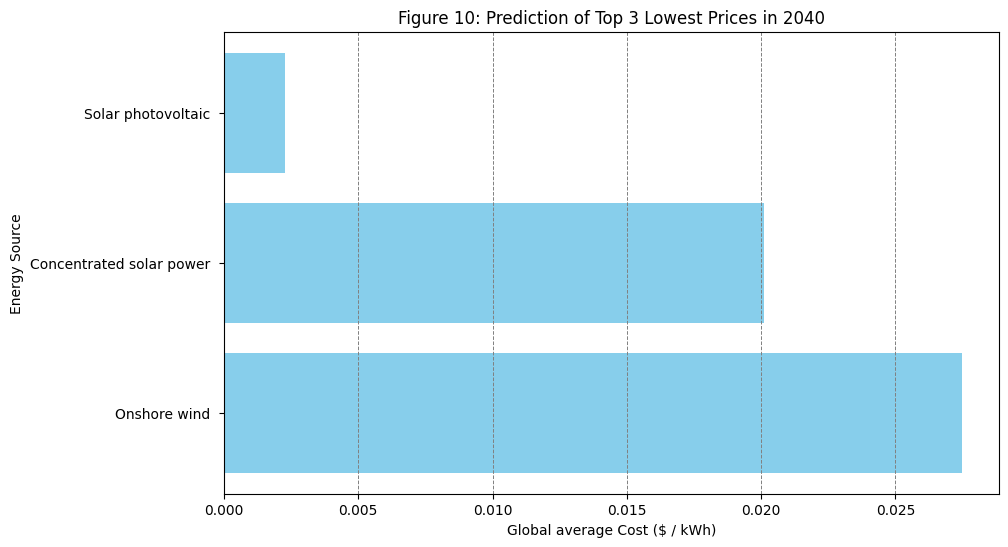

,Year,Energy Source,Cost ($/kWh)
0,2030,Solar photovoltaic,[0.012330146563452752]
1,2030,Onshore wind,[0.04212756370264991]
2,2030,Concentrated solar power,[0.05505599620457476]
3,2040,Solar photovoltaic,[0.002281540757125185]
4,2040,Concentrated solar power,[0.020097652576562427]
5,2040,Onshore wind,[0.027476829341156583]


In [47]:
cost_columns = [col for col in grouped_df_Q3.columns if 'cost' in col]

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.grid(axis='y', linestyle='--', linewidth='0.3', color='gray')

# Initiate prediction dicts
predictions_2030 = {}
predictions_2040 = {}

for col in cost_columns:
    label = col.split(' : ')[0]  # Keep only the part before ' : '

    df_int = grouped_df_Q3[col].interpolate(method='linear', limit=None).dropna() # create new df with interpolated values for NaN values

    # define x and y (x = year and y = energy costs)
    df_x = df_int.index.values.reshape(-1, 1)
    df_y = df_int.values

    # Add a small positive constant to ensure the dependent variable is never exactly zero, as it is expected that energy never will reach a negative cost
    epsilon = 1e-6
    df_y_transformed = np.log(df_y + epsilon)

    # Create and fit the polynomial regression model on transformed data
    model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
    model.fit(df_x, df_y_transformed)

    # Prediction model for display
    predictions_transformed = model.predict(df_x) # The model is used to make predictions on the independent variable x, resulting in transformed predictions
    predictions = np.exp(predictions_transformed) # undo the logarithmic transformation, resulting in predictions in the original scale of the dependent variable (df_y)

    # Plot the actual data and trendline
    plt.plot(df_int.index, df_y, label=label)
    plt.plot(df_int.index, predictions, linestyle=':', linewidth='1.0', color='red')
    plt.legend()
    plt.title(f'Figure 8: Global Average Price of Green Energy Sources')
    plt.xlabel('Year')
    plt.ylabel('$/kWh')

    # Predict cost for 2030
    prediction_2030_transformed = model.predict([[2030]])
    prediction_2030 = np.exp(prediction_2030_transformed)
    predictions_2030[label] = prediction_2030

    # Predict cost for 2040
    prediction_2040_transformed = model.predict([[2040]])
    prediction_2040 = np.exp(prediction_2040_transformed)
    predictions_2040[label] = prediction_2040

predictions = {
    2030: predictions_2030,
    2040: predictions_2040
}

figure_count = 9  # manual setting of figure count needed as running this section more times results in accumulation of the figure count

# Initialize an empty list
dfs_t3 = []

for year, prediction_data in predictions.items():
    top_3_lowest = sorted(prediction_data.items(), key=lambda x: x[1])[:3] # sorting should be based on the second element (index 1) of each item
    # unpack the tuples in top_3_lowest into separate lists for labels and values.
    labels, values = zip(*top_3_lowest)
    # print(type(values))
    # print(values)
    # Flatten and convert values to floats
    values = [float(val[0]) if isinstance(val, np.ndarray) else float(val) for val in values]

    # Create a DataFrame for the top 3 lowest predictions
    top_3_df = pd.DataFrame(top_3_lowest, columns=['Energy Source', 'Cost ($/kWh)'])
    top_3_df.insert(0, 'Year', year)  # Insert the year column as the first column
    # Append the DataFrame to the list
    dfs_t3.append(top_3_df)

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(labels, values, color='skyblue')
    plt.xlabel('Global average Cost ($ / kWh)')
    plt.ylabel('Energy Source')
    plt.title(f'Figure {figure_count}: Prediction of Top 3 Lowest Prices in {year}')
    plt.grid(axis='x', linestyle='--', linewidth='0.7', color='gray')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest price at the top
    plt.show()
    figure_count += 1

top_3_dataframe = pd.concat(dfs_t3, ignore_index=True)

display(top_3_dataframe)


In [21]:
# space used for (missing) value-analysis and analysis of dataframe content
# can be ignored
find_missing_countries(merged_df_Q1, 'Entity')

find_non_default_missing_values(filtered_df, 'Year', int)

Missing countries: ['Holy See', 'Monaco', 'San Marino']
Possible matches for 'Holy See': {'Holy': [], 'See': []}
Possible matches for 'Monaco': {'Monaco': []}
Possible matches for 'San Marino': {'Marino': [], 'San': []}


********************************************************************************
Finding non default missing values for column "Year"
********************************************************************************
Column "Year" has datatype: int64


----------------------------------------
A: Looking at unique values
----------------------------------------
Less than 160 unique values:
Values are sorted


[2000, 2022]



----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[2000, 2022]

[2000, 2022]



----------------------------------------
C: Casting to type: <class 'int'>
----------------------------------------
Casting to <class 'int'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


2022    231
2000    230
Name: Year, dtype: int64